<a href="https://colab.research.google.com/github/yasego/HandsOnML/blob/main/hands_on_ml_ch17_ex9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version은 코랩에서만 동작합니다.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

9. 잡음 제거 오토인코더를 사용해 이미지 분류기를 사전훈련해보세요.

* 데이터셋을 훈련 세트와 테스트 세트로 나눕니다. 전체 훈련 세트에서 심층 잡음 제거 오토인코더를 훈련합니다.

* 이미지가 잘 재구성되는 지 확인하세요. 코딩 층의 각 뉴런을 가장 크게 활성화하는 이미지를 시각화해보세요.

* 이 오토인코더의 아래 층을 재사용해 분류 DNN을 만드세요. 훈련 세트에서 이미지 500개만 사용해 훈련합니다. 사전훈련을 사용하는 것이 더 나은가요? 사용하지 않는 것이 더 나은가요?

In [2]:
[X_train, y_train], [X_test, y_test] = keras.datasets.cifar10.load_data()
X_train = X_train / 255
X_test = X_test / 255

170498071/170498071 [==============================] - 11s 0us/step


In [3]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.GaussianNoise(0.1, input_shape=[32, 32, 3]),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),
])

In [4]:
denoising_encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNoi  (None, 32, 32, 3)        0         
 se)                                                             
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
Total params: 4,195,712
Trainable params: 4,195,712
Non-

In [5]:
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(16 * 16 * 32, activation="relu", input_shape=[512]),
    keras.layers.Reshape([16, 16, 32]),
    keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2,
                                 padding="same", activation="sigmoid")
])

In [6]:
denoising_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              4202496   
                                                                 
 reshape (Reshape)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 3)        867       
 nspose)                                                         
                                                                 
Total params: 4,203,363
Trainable params: 4,203,363
Non-trainable params: 0
_________________________________________________________________


In [7]:
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Nadam(),
                     metrics=["mse"])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_test, X_test))

Epoch 1/10
1563/1563 [==============================] - 350s 223ms/step - loss: 0.5846 - mse: 0.0149 - val_loss: 0.6027 - val_mse: 0.0202
Epoch 2/10
1563/1563 [==============================] - 325s 208ms/step - loss: 0.5677 - mse: 0.0080 - val_loss: 0.5817 - val_mse: 0.0117
Epoch 3/10
1563/1563 [==============================] - 326s 209ms/step - loss: 0.5645 - mse: 0.0067 - val_loss: 0.5772 - val_mse: 0.0101
Epoch 4/10
1563/1563 [==============================] - 324s 207ms/step - loss: 0.5632 - mse: 0.0062 - val_loss: 0.5746 - val_mse: 0.0093
Epoch 5/10
1563/1563 [==============================] - 317s 203ms/step - loss: 0.5625 - mse: 0.0060 - val_loss: 0.5665 - val_mse: 0.0069
Epoch 6/10
1563/1563 [==============================] - 315s 202ms/step - loss: 0.5620 - mse: 0.0058 - val_loss: 0.5670 - val_mse: 0.0072
Epoch 7/10
1563/1563 [==============================] - 314s 201ms/step - loss: 0.5616 - mse: 0.0057 - val_loss: 0.5659 - val_mse: 0.0068
Epoch 8/10
1563/1563 [============

1/1 [==============================] - 0s 167ms/step


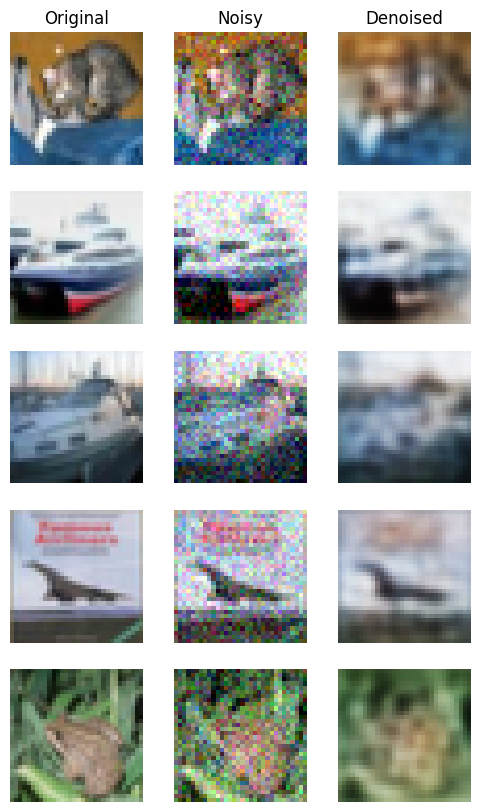

In [8]:
n_images = 5
new_images = X_test[:n_images]
new_images_noisy = new_images + np.random.randn(n_images, 32, 32, 3) * 0.1
new_images_denoised = denoising_ae.predict(new_images_noisy)

plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(new_images[index])
    plt.axis('off')
    if index == 0:
        plt.title("Original")
    plt.subplot(n_images, 3, index * 3 + 2)
    plt.imshow(np.clip(new_images_noisy[index], 0., 1.))
    plt.axis('off')
    if index == 0:
        plt.title("Noisy")
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(new_images_denoised[index])
    plt.axis('off')
    if index == 0:
        plt.title("Denoised")
plt.show()